In [1]:
# import the necessary packages
import matplotlib
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model
from keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils import paths
import argparse
import random
import pickle
import cv2
import os
#Need model output 
#Need Label bin
#Plot pin

Using TensorFlow backend.


In [4]:
# import the necessary packages
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.models import Model
from keras import layers
from keras import backend as K

def build_nottrainable(classes):
    model = VGG16(include_top=False, weights='imagenet',input_shape=(224, 224, 3))
    transfer_layer = model.get_layer('block5_pool')
    conv_model = Model(inputs=model.input,outputs=transfer_layer.output)
    #conv_model.trainable = False
    for layer in conv_model.layers:
        layer.trainable = False

    new_model = Sequential()
    new_model.add(conv_model)
    #Flatten the output of the VGG16 model because its from Conv Layer		
    new_model.add(layers.Flatten())
    #Add a dense fully connected layer
    new_model.add(layers.Dense(1024, activation = 'relu'))
    new_model.add(layers.Dropout(0.5))
    new_model.add(layers.Dense(classes, activation = 'sigmoid'))

    # return the constructed network architecture
    return new_model

def build_trainable(classes):
    model = VGG16(include_top=False, weights='imagenet',input_shape=(224, 224, 3))
    transfer_layer = model.get_layer('block5_pool')
    conv_model = Model(inputs=model.input,outputs=transfer_layer.output)
    #conv_model.trainable = False
    #for layer in conv_model.layers:
    #    layer.trainable = False
    new_model = Sequential()
    new_model.add(conv_model)
    #Flatten the output of the VGG16 model because its from Conv Layer		
    new_model.add(layers.Flatten())
    #Add a dense fully connected layer
    new_model.add(layers.Dense(1024, activation = 'relu'))
    new_model.add(layers.Dropout(0.5))
    new_model.add(layers.Dense(classes, activation = 'sigmoid'))

    # return the constructed network architecture
    return new_model

In [5]:
def csv_image_generator_double(inputPath, bs, mlb, mode="train", aug=None):
    # open the CSV file for reading
    f = open(inputPath, "r")
    IMAGE_DIMS = (224, 224, 3)
    # loop indefinitely	
    while True:
        # initialize our batches of images and labels
        images = []
        labels = []
        # keep looping until we reach our batch size
        while len(images) < bs:
            # attempt to read the next line of the CSV file
            line = f.readline()
            # check to see if the line is empty, indicating we have
            # reached the end of the file
            if line == "":
                # reset the file pointer to the beginning of the file
                # and re-read the line
                f.seek(0)
                line = f.readline()

                # if we are evaluating we should now break from our
                # loop to ensure we don't continue to fill up the
                # batch from samples at the beginning of the file
                if mode == "eval":
                    break

            # extract the label and construct the image
            line = line.strip().split(",")
            label = line[1]
            label = [line[0],line[1]]

            image = np.array([int(x) for x in line[2:]], dtype="uint8")
            image = image.reshape((224, 224, 3))
            image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
            #image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
            image = img_to_array(image)
            # update our corresponding batches lists
            images.append(image)
            labels.append(label)

        # scale the raw pixel intensities to the range [0, 1]
        images = np.array(images, dtype="float") / 255.0
        # one-hot encode the labels
        labels = np.array(labels)
        labels = mlb.transform(labels)

        # if the data augmentation object is not None, apply it
        if aug is not None:
            (images, labels) = next(aug.flow(images,
                labels, batch_size=bs))

        # yield the batch to the calling function
        yield (images, labels)

In [6]:
def csv_image_generator_single(inputPath, bs, mlb, mode="train", aug=None):
    # open the CSV file for reading
    f = open(inputPath, "r")
    IMAGE_DIMS = (224, 224, 3)
    # loop indefinitely	
    while True:
        # initialize our batches of images and labels
        images = []
        labels = []
        # keep looping until we reach our batch size
        while len(images) < bs:
            # attempt to read the next line of the CSV file
            line = f.readline()
            # check to see if the line is empty, indicating we have
            # reached the end of the file
            if line == "":
                # reset the file pointer to the beginning of the file
                # and re-read the line
                f.seek(0)
                line = f.readline()

                # if we are evaluating we should now break from our
                # loop to ensure we don't continue to fill up the
                # batch from samples at the beginning of the file
                if mode == "eval":
                    break

            # extract the label and construct the image
            line = line.strip().split(",")
            label = line[0]

            image = np.array([int(x) for x in line[1:]], dtype="uint8")
            image = image.reshape((224, 224, 3))
            image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
            #image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
            image = img_to_array(image)
            # update our corresponding batches lists
            images.append(image)
            labels.append(label)

        # scale the raw pixel intensities to the range [0, 1]
        images = np.array(images, dtype="float") / 255.0
        # one-hot encode the labels
        labels = np.array(labels)
        labels = mlb.transform(labels)

        # if the data augmentation object is not None, apply it
        if aug is not None:
            (images, labels) = next(aug.flow(images,
                labels, batch_size=bs))

        # yield the batch to the calling function
        yield (images, labels)

In [7]:
def extract_mlb_double(dir_out,TRAIN_CSV,TEST_CSV,VAL_CSV):
    # open the training CSV file, then initialize the unique set of class
    # labels in the dataset along with the testing labels
    f = open(TRAIN_CSV, "r")
    #labels = set()
    labels = []
    testLabels = []
    validLabels = []
    NUM_TRAIN_IMAGES = 0
    NUM_TEST_IMAGES = 0
    NUM_VAL_IMAGES = 0
    # loop over all rows of the CSV file
    for line in f:
        # extract the class label, update the labels list, and increment
        # the total number of training images
        label = line.strip().split(",")[0]
        label1 = line.strip().split(",")[1]
        label = [label,label1]
        labels.append(label)
        #labels.add(label)
        #labels.add(label1)
        NUM_TRAIN_IMAGES += 1

    # close the training CSV file and open the testing CSV file
    f.close()
    f = open(TEST_CSV, "r")

    # loop over the lines in the testing file
    for line in f:
        # extract the class label, update the test labels list, and
        # increment the total number of testing images
        label = line.strip().split(",")[0]
        label1 = line.strip().split(",")[1]
        label = [label,label1]
        testLabels.append(label)
        NUM_TEST_IMAGES += 1

    # close the testing CSV file
    f.close()
    
    f = open(VAL_CSV, "r")

    # loop over the lines in the testing file
    for line in f:
        # extract the class label, update the test labels list, and
        # increment the total number of testing images
        label = line.strip().split(",")[0]
        label1 = line.strip().split(",")[1]
        label = [label,label1]
        validLabels.append(label)
        NUM_VAL_IMAGES += 1

    # close the testing CSV file
    f.close()

    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    testLabels = mlb.fit_transform(testLabels)
    validLabels = mlb.fit_transform(validLabels)
    output_dir = "pickle_models/"+dir_out
    # save the multi-label binarizer to disk
    print("[INFO] serializing label binarizer...")
    f = open(output_dir, "wb")
    f.write(pickle.dumps(mlb))
    f.close()
    
    return testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES

In [8]:
def extract_mlb_single(dir_out,TRAIN_CSV,TEST_CSV,VAL_CSV):
    # open the training CSV file, then initialize the unique set of class
    # labels in the dataset along with the testing labels
    f = open(TRAIN_CSV, "r")
    #labels = set()
    labels = []
    testLabels = []
    validLabels = []
    NUM_TRAIN_IMAGES = 0
    NUM_TEST_IMAGES = 0
    NUM_VAL_IMAGES = 0
    # loop over all rows of the CSV file
    for line in f:
        # extract the class label, update the labels list, and increment
        # the total number of training images
        label = line.strip().split(",")[0]
        labels.append(label)
        NUM_TRAIN_IMAGES += 1

    # close the training CSV file and open the testing CSV file
    f.close()
    f = open(TEST_CSV, "r")

    # loop over the lines in the testing file
    for line in f:
        # extract the class label, update the test labels list, and
        # increment the total number of testing images
        label = line.strip().split(",")[0]
        testLabels.append(label)
        NUM_TEST_IMAGES += 1

    # close the testing CSV file
    f.close()
    
    f = open(TEST_CSV, "r")

    # loop over the lines in the testing file
    for line in f:
        # extract the class label, update the test labels list, and
        # increment the total number of testing images
        label = line.strip().split(",")[0]
        validLabels.append(label)
        NUM_VAL_IMAGES += 1

    # close the testing CSV file
    f.close()

    mlb = LabelBinarizer()
    labels = mlb.fit_transform(labels)
    testLabels = mlb.fit_transform(testLabels)
    validLabels = mlb.fit_transform(validLabels)

    output_dir = "pickle_models/"+dir_out
    # save the multi-label binarizer to disk
    print("[INFO] serializing label binarizer...")
    f = open(output_dir, "wb")
    f.write(pickle.dumps(mlb))
    f.close()
    
    return testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES

In [9]:
def train_model(name,train,NUM_EPOCHS,learning_rate,weights,mlb,TRAIN_CSV,Val_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES):
    # construct the training image generator for data augmentation
    aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=True, fill_mode="nearest")

    # initialize both the training and testing image generators
    trainGen = csv_image_generator_single(TRAIN_CSV, BS, mlb,
    mode="train", aug=None)
    valGen = csv_image_generator_single(Val_CSV, BS, mlb,
    mode="train", aug=None)
    
    if train == True:
        # initialize our Keras model and compile it
        model = build_trainable(classes=len(mlb.classes_))
    else:
        model = build_nottrainable(classes=len(mlb.classes_))
    
    if weights != None:
        model.load_weights(weights)
    
    #Using binary cross entropy 
    #opt = SGD(lr=learning_rate, momentum=0.9, decay=1e-2 / NUM_EPOCHS,nesterov=True)
    opt = Adam(lr=learning_rate, decay=learning_rate / NUM_EPOCHS)
    model.compile(loss="binary_crossentropy", optimizer=opt,
        metrics=["accuracy"])
    # train the network
    print("[INFO] training w/ generator...")
    H = model.fit_generator(
        trainGen,
        steps_per_epoch=NUM_TRAIN_IMAGES // BS,
        validation_data=valGen,
        validation_steps=NUM_VAL_IMAGES // BS,
        epochs=NUM_EPOCHS)
    plot_name = "plots/"+name + "_plot.png"
    # plot the training loss and accuracy
    N = NUM_EPOCHS
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plot_name)

    return model
    

In [10]:
import pandas as pd

def evaluate_model(report_name,mlb,BS,model,NUM_TEST_IMAGES,testLabels):
    # re-initialize our testing data generator, this time for evaluating
    testGen = csv_image_generator_single(TEST_CSV, BS, mlb,
        mode="eval", aug=None)
    # make predictions on the testing images, finding the index of the
    # label with the corresponding largest predicted probability
    predIdxs = model.predict_generator(testGen,
        steps=(NUM_TEST_IMAGES // BS) + 1)
    predIdxs = np.argmax(predIdxs, axis=1)
    
    print("[INFO] evaluating network...")
    print(classification_report(testLabels.argmax(axis=1), predIdxs,
    target_names=mlb.classes_))

    report = classification_report(testLabels.argmax(axis=1), predIdxs, target_names=mlb.classes_)
    report_data = []
    lines = report.split('\n')

    for line in lines[2:]:
        try:
            row = {}
            row_data = line.split('      ')
            print(row_data)
            row['class'] = row_data[1]
            row['precision'] = float(row_data[2])
            row['recall'] = float(row_data[3])
            row['f1_score'] = float(row_data[4])
            row['support'] = float(row_data[5])
            report_data.append(row)
        except:
            pass
    dataframe = pd.DataFrame.from_dict(report_data)
    write_name = "reports/"+report_name+".csv"
    dataframe.to_csv(write_name, index = False)

In [46]:
TRAIN_CSV = "datasetClothes_training.csv"
TEST_CSV = "datasetClothes_testing.csv"
VAL_CSV = "datasetClothes_validation.csv"
NUM_TRAIN_IMAGES = 0
NUM_TEST_IMAGES = 0
NUM_VAL_IMAGES = 0
# initialize the number of epochs to train for and batch size
NUM_EPOCHS = 5
EPOCHS = 5
BS = 32
Learning_rate_1 = 0.001
Learning_rate_2 = 0.00001

output_dir = "fashion_SGD.pickle"
testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES = extract_mlb_double(output_dir,TRAIN_CSV,TEST_CSV,VAL_CSV)
#print(NUM_TRAIN_IMAGES)
#print(NUM_TEST_IMAGES)
#print(NUM_VAL_IMAGES)
pickle_dir = "pickle_models/"+output_dir
mlb = pickle.loads(open(pickle_dir, "rb").read())
#mlb = pickle.loads(open(args["labelbin"], "rb").read())

[INFO] serializing label binarizer...


In [ ]:
name = "Fashion_Train1"
model = train_model(name,False,NUM_EPOCHS,Learning_rate_1,None,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
print("[INFO] serializing network...")
model.save("models/fashion.h5")
name = "Fashion_Train2"
model = train_model(name,True,NUM_EPOCHS,Learning_rate_1,"models/fashion.h5",mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
model.save("models/fashion.h5")
name = "Fashion_Final"
model = train_model(name,True,NUM_EPOCHS,Learning_rate_2,"models/fashion.h5",mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
model.save("models/fashion.h5")

[INFO] serializing label binarizer...
[INFO] training w/ generator...
Epoch 1/5
1425/1425 [==============================] - 2108s 1s/step - loss: 0.2113 - acc: 0.9310 - val_loss: 0.1878 - val_acc: 0.9377
Epoch 2/5
1425/1425 [==============================] - 2092s 1s/step - loss: 0.1956 - acc: 0.9358 - val_loss: 0.1836 - val_acc: 0.9384
Epoch 3/5
1425/1425 [==============================] - 2130s 1s/step - loss: 0.1915 - acc: 0.9368 - val_loss: 0.1818 - val_acc: 0.9385
Epoch 4/5
1425/1425 [==============================] - 2066s 1s/step - loss: 0.1899 - acc: 0.9371 - val_loss: 0.1806 - val_acc: 0.9386
Epoch 5/5
1425/1425 [==============================] - 2027s 1s/step - loss: 0.1884 - acc: 0.9371 - val_loss: 0.1798 - val_acc: 0.9386
[INFO] serializing network...
[INFO] training w/ generator...
Epoch 1/5
1425/1425 [==============================] - 1944s 1s/step - loss: 0.1789 - acc: 0.9387 - val_loss: 0.1677 - val_acc: 0.9411
Epoch 2/5
1425/1425 [==============================] - 192

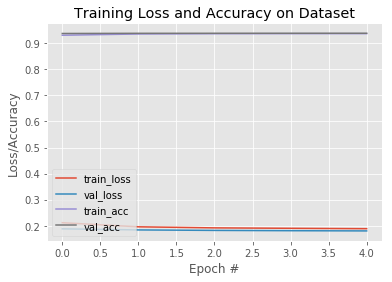

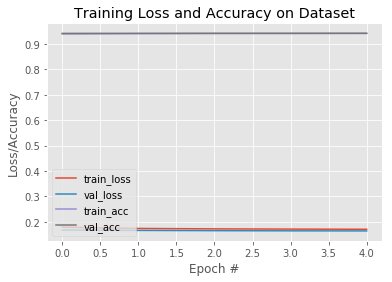

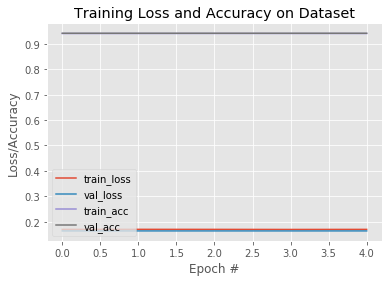

In [10]:
TRAIN_CSV = "Union_WB_B_spatial_training.csv"
TEST_CSV = "Union_WB_B_spatial_testing.csv"
VAL_CSV = "Union_WB_B_spatial_validation.csv"
NUM_TRAIN_IMAGES = 0
NUM_TEST_IMAGES = 0
NUM_VAL_IMAGES = 0
# initialize the number of epochs to train for and batch size
NUM_EPOCHS = 5
EPOCHS = 5
BS = 32
Learning_rate_1 = 0.001
Learning_rate_2 = 0.00001

output_dir = "Union_WB_B.pickle"
testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES = extract_mlb_single(output_dir,TRAIN_CSV,TEST_CSV,VAL_CSV)
pickle_dir = "pickle_models/"+output_dir
mlb = pickle.loads(open(pickle_dir, "rb").read())

name = "Union_WB_B"
model = train_model(name,False,NUM_EPOCHS,Learning_rate_1,None,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
print("[INFO] serializing network...")
model.save("models/Union_WB_B.h5")
name = "Union_WB_B2"
model = train_model(name,True,NUM_EPOCHS,Learning_rate_1,"models/Union_WB_B.h5",mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
model.save("models/Union_WB_B.h5")
name = "Union_WB_B_Final"
model = train_model(name,True,NUM_EPOCHS,Learning_rate_2,"models/Union_WB_B.h5",mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
model.save("models/Union_WB_B.h5")

In [11]:
evaluate_model("Union_WB_B",mlb,BS,model,NUM_TEST_IMAGES,testLabels)

[INFO] evaluating network...


/home/nuclearvodka/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       above       0.58      0.59      0.58      1448
      behind       0.32      0.14      0.19      1273
       below       0.30      0.06      0.10       503
     beneath       0.00      0.00      0.00       165
       front       0.00      0.00      0.00         1
         has       0.70      0.88      0.78      2733
          in       0.30      0.10      0.14      1650
        left       0.00      0.00      0.00        53
        near       0.11      0.01      0.02       785
        next       0.36      0.47      0.41      1321
          on       0.62      0.87      0.72      4307
       right       0.00      0.00      0.00        32
       under       0.33      0.44      0.38       930

   micro avg       0.55      0.55      0.55     15201
   macro avg       0.28      0.27      0.26     15201
weighted avg       0.48      0.55      0.50     15201

['', ' above', ' 0.58', '0.59', '0.58', '1448']
['', 'behind', ' 0.32', '0.14',

In [14]:
from sklearn.preprocessing import LabelBinarizer

def extract_mlb(dir_out,TEST_CSV):
    NUM_TEST_IMAGES = 0
    testLabels = []
    
    f = open(TEST_CSV, "r")

    # loop over the lines in the testing file
    for line in f:
        # extract the class label, update the test labels list, and
        # increment the total number of testing images
        label = line.strip().split(",")[0]
        testLabels.append(label)
        NUM_TEST_IMAGES += 1

    # close the testing CSV file
    f.close()
    lb = LabelBinarizer()
    #mlb = MultiLabelBinarizer()
    testLabels = lb.fit_transform(testLabels)
    
    #output_dir = "pickle_models/"+dir_out
    #save the multi-label binarizer to disk
    #print("[INFO] serializing label binarizer...")
    #f = open(output_dir, "wb")
    #f.write(pickle.dumps(mlb))
    #f.close()
    
    return lb,testLabels,NUM_TEST_IMAGES

output_dir = "Union_WB_B.pickle"
TEST_CSV = "Union_WB_B_spatial_testing.csv"
lb,testLabels,NUM_TEST_IMAGES = extract_mlb(output_dir,TEST_CSV)
print(lb.classes_)
#pickle_dir = "pickle_models/"+output_dir
#mlb = pickle.loads(open(pickle_dir, "rb").read())
BS = 32
#model = build_trainable(classes=len(mlb.classes_))
#model.load_weights("models/Union_WB_B.h5")

['above' 'behind' 'below' 'beneath' 'front' 'has' 'in' 'left' 'near'
 'next' 'on' 'right' 'under']


In [ ]:
print(mlb.classes_)

[INFO] serializing label binarizer...
[INFO] training w/ generator...
Epoch 1/3
1425/1425 [==============================] - 2210s 2s/step - loss: 0.2424 - acc: 0.9205 - val_loss: 0.2044 - val_acc: 0.9240
Epoch 2/3
1425/1425 [==============================] - 2215s 2s/step - loss: 0.2112 - acc: 0.9240 - val_loss: 0.2010 - val_acc: 0.9246
Epoch 3/3
1425/1425 [==============================] - 2244s 2s/step - loss: 0.2047 - acc: 0.9252 - val_loss: 0.1980 - val_acc: 0.9250
[INFO] serializing network...
[INFO] training w/ generator...
Epoch 1/3
1425/1425 [==============================] - 2226s 2s/step - loss: 0.2262 - acc: 0.9228 - val_loss: 0.2101 - val_acc: 0.9231
Epoch 2/3
1425/1425 [==============================] - 2232s 2s/step - loss: 0.2134 - acc: 0.9225 - val_loss: 0.2057 - val_acc: 0.9231
Epoch 3/3
1425/1425 [==============================] - 2197s 2s/step - loss: 0.2084 - acc: 0.9228 - val_loss: 0.2031 - val_acc: 0.9233
[INFO] training w/ generator...
Epoch 1/3
1425/1425 [=====

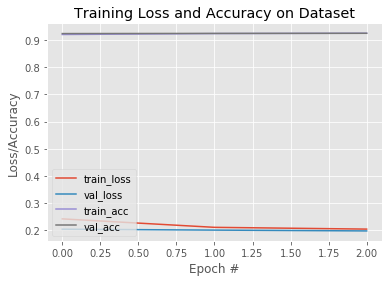

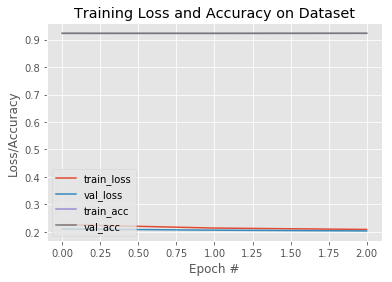

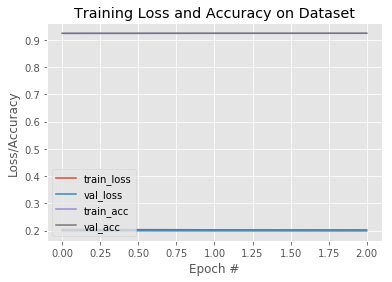

In [11]:
TRAIN_CSV = "Union_WB_spatial_training.csv"
TEST_CSV = "Union_WB_spatial_testing.csv"
VAL_CSV = "Union_WB_spatial_validation.csv"
NUM_TRAIN_IMAGES = 0
NUM_TEST_IMAGES = 0
NUM_VAL_IMAGES = 0
# initialize the number of epochs to train for and batch size
NUM_EPOCHS = 3
EPOCHS = 3
BS = 32
Learning_rate_1 = 0.001
Learning_rate_2 = 0.00001

output_dir = "Union_WB_Adam.pickle"
testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES = extract_mlb_single(output_dir,TRAIN_CSV,TEST_CSV,VAL_CSV)
pickle_dir = "pickle_models/"+output_dir
mlb = pickle.loads(open(pickle_dir, "rb").read())

name = "Union_WB_Adam"
model = train_model(name,False,NUM_EPOCHS,Learning_rate_1,None,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
print("[INFO] serializing network...")
model.save("models/Union_WB_Adam.h5")
name = "Union_WB_Adam2"
model = train_model(name,True,NUM_EPOCHS,Learning_rate_1,"models/Union_WB_Adam.h5",mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
model.save("models/Union_WB_Adam.h5")
name = "Union_WB_Adam_Final"
model = train_model(name,True,NUM_EPOCHS,Learning_rate_2,"models/Union_WB_Adam.h5",mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
model.save("models/Union_WB_Adam.h5")

In [12]:
evaluate_model("Union_WB",mlb,BS,model,NUM_TEST_IMAGES,testLabels)

[INFO] evaluating network...
              precision    recall  f1-score   support

       above       0.38      0.59      0.47      1419
      behind       0.24      0.07      0.11      1259
       below       0.00      0.00      0.00       499
     beneath       0.00      0.00      0.00       156
       front       0.00      0.00      0.00         4
         has       0.46      0.41      0.43      2696
          in       0.25      0.06      0.09      1663
        left       0.00      0.00      0.00        47
        near       0.00      0.00      0.00       753
        next       0.32      0.54      0.40      1360
          on       0.41      0.72      0.52      4385
       right       0.00      0.00      0.00        41
       under       0.00      0.00      0.00       919

   micro avg       0.39      0.39      0.39     15201
   macro avg       0.16      0.18      0.16     15201
weighted avg       0.31      0.39      0.33     15201



/home/nuclearvodka/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


['', ' above', ' 0.38', '0.59', '0.47', '1419']
['', 'behind', ' 0.24', '0.07', '0.11', '1259']
['', ' below', ' 0.00', '0.00', '0.00', ' 499']
['     beneath', ' 0.00', '0.00', '0.00', ' 156']
['', ' front', ' 0.00', '0.00', '0.00', '   4']
['', '   has', ' 0.46', '0.41', '0.43', '2696']
['', '    in', ' 0.25', '0.06', '0.09', '1663']
['', '  left', ' 0.00', '0.00', '0.00', '  47']
['', '  near', ' 0.00', '0.00', '0.00', ' 753']
['', '  next', ' 0.32', '0.54', '0.40', '1360']
['', '    on', ' 0.41', '0.72', '0.52', '4385']
['', ' right', ' 0.00', '0.00', '0.00', '  41']
['', ' under', ' 0.00', '0.00', '0.00', ' 919']
['']
['   micro avg', ' 0.39', '0.39', '0.39     15201']
['   macro avg', ' 0.16', '0.18', '0.16     15201']
['weighted avg', ' 0.31', '0.39', '0.33     15201']
['']


In [ ]:
model.summary()

In [9]:
from vis.utils import utils
from keras import activations

model1 = build_nottrainable(classes=13)
model1.load_weights("models/Union_WB_B.h5")
model1.summary()
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                13325     
Total params: 40,419,149
Trainable params: 25,704,461
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
layer_idx = utils.find_layer_idx(model1, 'dense_2')

# Swap sigmoidlinear
model1.layers[layer_idx].activation = activations.linear
model1 = utils.apply_modifications(model1)

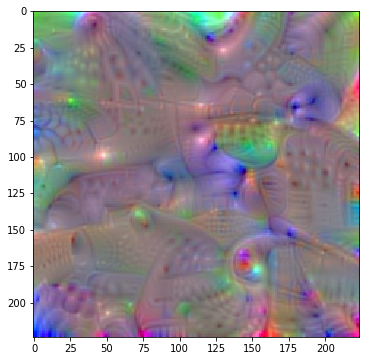

In [20]:
from vis.visualization import visualize_activation
from matplotlib import pyplot as plt
from vis.input_modifiers import Jitter

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# 20 is the imagenet category for 'ouzel'
#for i in range(10):
img = visualize_activation(model1, layer_idx, filter_indices=0, max_iter=1024)
plt.imshow(img)

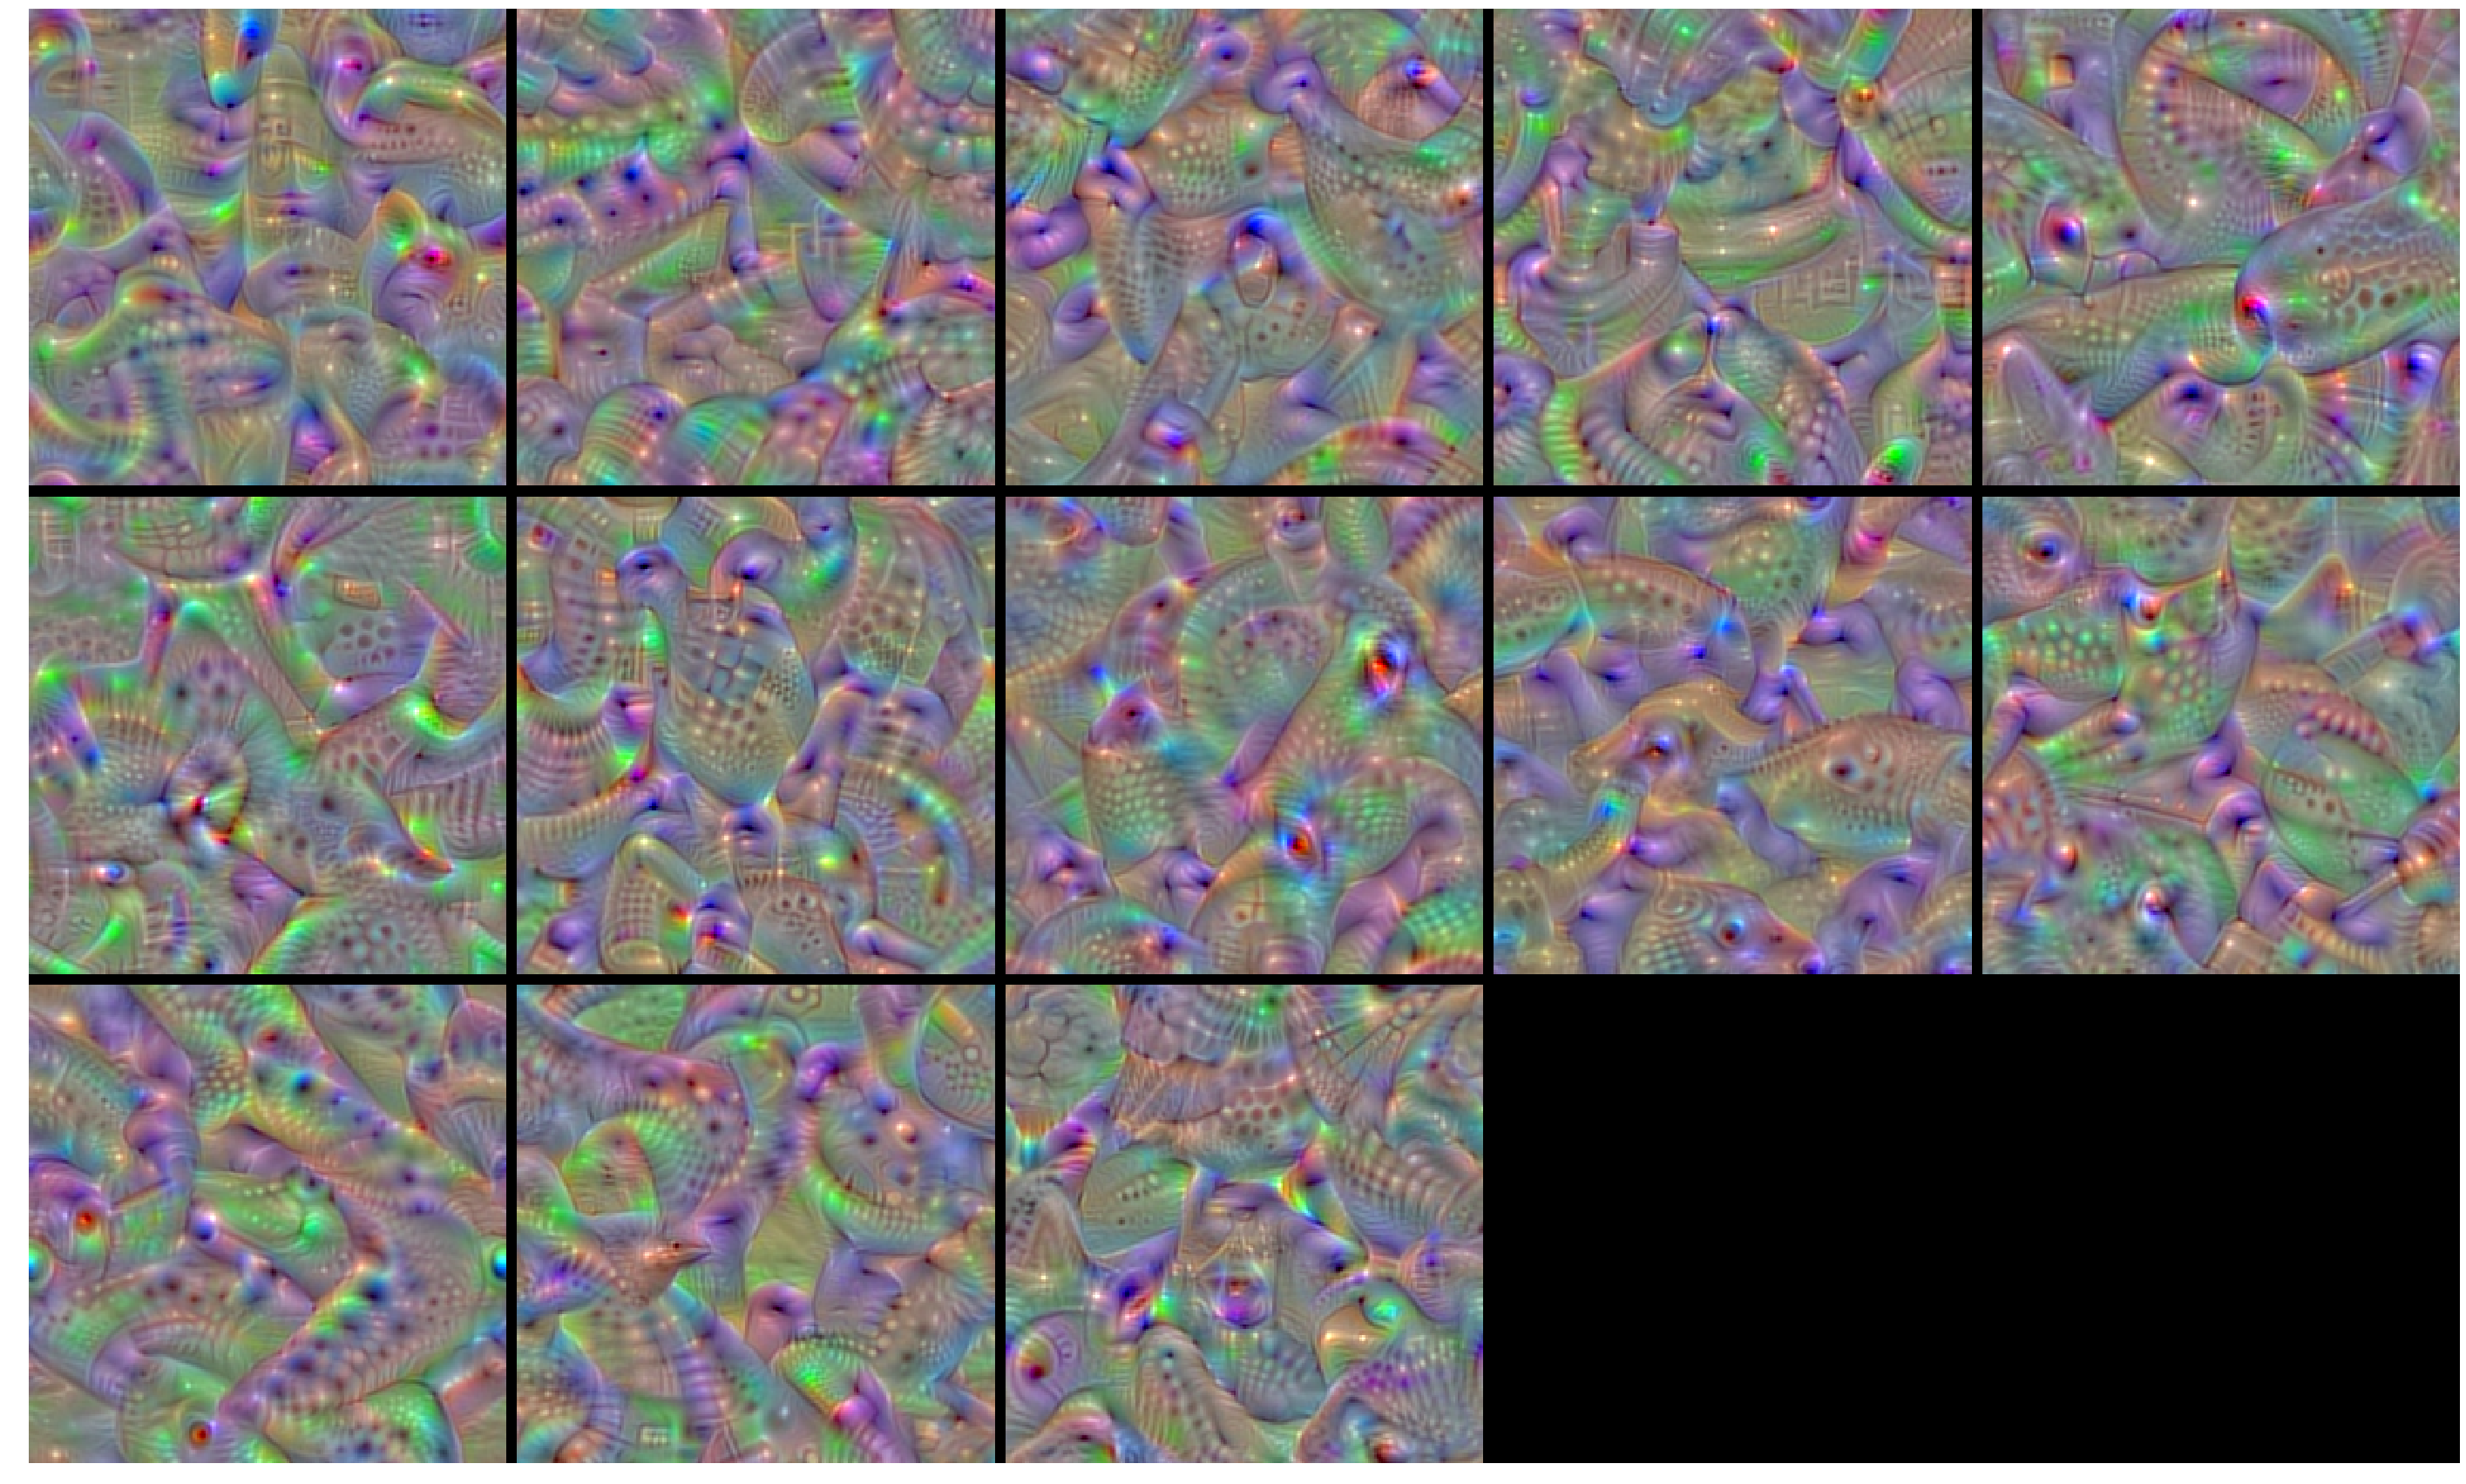

In [17]:
import numpy as np
from vis.input_modifiers import Jitter

categories = np.random.permutation(13)[:15]

vis_images = []
image_modifiers = [Jitter(16)]
for idx in categories:    
    img = visualize_activation(model1, layer_idx, filter_indices=idx, max_iter=500, input_modifiers=image_modifiers)
    
    # Reverse lookup index to imagenet label and overlay it on the image.
    #img = utils.draw_text(img, utils.get_imagenet_label(idx))
    vis_images.append(img)

# Generate stitched images with 5 cols (so it will have 3 rows).
plt.rcParams['figure.figsize'] = (50, 50)
stitched = utils.stitch_images(vis_images, cols=5)
plt.axis('off')
plt.imshow(stitched)
plt.show()